# Прогнозирование оттока клиентов банка
---

   


#### Постановка бизнес-задачи, описание предметной области. <a name="first-stage" id="first-stage"></a>  

##### Предметная область
Рассматривается задача прогнозирования оттока клиентов банка. Отток (churn) - прекращение использования клиентом банковских услуг. Удержание клиентов - приоритет для бизнеса из-за высокой стоимости их привлечения.  


##### Контекст бизнеса

**Банки стремятся**:
- Выявлять клиентов с высоким риском ухода
- Повышать уровень удержания
- Персонализировать предложения

**Ключевые аспекты:**
- Своевременное выявление оттока
- Оптимизация маркетинговых и удерживающих кампаний
- Увеличение прибыли за счёт лояльных клиентов



##### Бизнес-задача
Бизнес-задача – на основе имеющихся данных о клиентах проанализировать датасет для выявления причин ухода клиентов.

**Цель:**
- Снизить отток клиентов
- Поддержки стабильной прибыли банков
- Улучшения стратегий взаимодействия с клиентами


##### Описание набора данных
**Источник:** Kaggle - [Bank Customer Churn Prediction](https://www.kaggle.com/datasets/shubhammeshram579/bank-customer-churn-prediction)  
**Объём:** ~10 000 клиентов  
**Целевая переменная:** `Exited` (1 — клиент ушёл, 0 — остался)

**Основные признаки**

| Признак                | Тип            | Описание                                                  |
|:-                      |:-:             |:-                                                         |
| `CustomerId`           | Integer        | Уникальный идентификатор клиента                          |
| `Surname`              | String         | Фамилия клиента                                           |
| `CreditScore`          | Integer        | Кредитный рейтинг клиента                                 |
| `Geography`            | String         | Страна проживания                                         |
| `Gender`               | String         | Пол клиента                                               |
| `Age`                  | Integer        | Возраст клиента                                           |
| `Tenure`               | Integer        | Лет сотрудничества                                        |
| `Balance`              | Float          | Остаток на счёте                                          |
| `NumOfProducts`        | Integer        | Кол-во продуктов банка                                    |
| `HasCrCard`            | Integer        | Наличие кредитной карты                                   |
| `IsActiveMember`       | Float          | Активность клиента                                        |
| `EstimatedSalary`      | Float          | Предполагаемый доход                                      |
| `Exited`               | Integer        | Ушел ли клиент или нет (целевая переменная)               |


##### Условные договоренности
1. Будем считать, что кредитный рейтинг >=750 - это хороший кредитный рейтинг
2. Будем считать, что кредитный рейтинг <=500 - это низкий кредитный рейтинг
3. Будем считать, что клиенты с балансом >=200 000 - это особо важные (VIP) клиенты
---

#### Предобработка данных <a name="content-1" id="content-1"></a>

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind, fisher_exact

##### Знакомство с данными <a name="content-11" id="content-11"></a>

In [2]:
# Загрузка дата сета
dataset = pd.read_csv("../data/churn.csv")
dataset

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9997,9998,15584532,Liu,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
9999,9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
10000,10000,15628319,Walker,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0


In [3]:
# первые 10 строк
dataset.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44.0,8,113755.78,2,1.0,0.0,149756.71,1
6,7,15592531,Bartlett,822,NaN,Male,50.0,7,0.00,2,1.0,1.0,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29.0,4,115046.74,4,1.0,0.0,119346.88,1
8,9,15792365,He,501,France,Male,44.0,4,142051.07,2,0.0,NaN,74940.50,0
9,10,15592389,H?,684,France,Male,NaN,2,134603.88,1,1.0,1.0,71725.73,0


In [4]:
# последние 10 строк
dataset.tail(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9992,9993,15657105,Chukwualuka,726,Spain,Male,36.0,2,0.00,1,1.0,0.0,195192.40,0
9993,9994,15569266,Rahman,644,France,Male,28.0,7,155060.41,1,1.0,0.0,29179.52,0
9994,9995,15719294,Wood,800,France,Female,29.0,2,0.00,2,0.0,0.0,167773.55,0
9995,9996,15606229,Obijiaku,771,France,Male,39.0,5,0.00,2,1.0,0.0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35.0,10,57369.61,1,1.0,1.0,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
9999,9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
10000,10000,15628319,Walker,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0
10001,10000,15628319,Walker,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0


In [5]:
# случайные 10 строк
dataset.sample(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
6885,6886,15606849,Blackall,698,France,Female,27.0,1,94920.71,1,1.0,1.0,40339.90,0
4262,4263,15585222,Norman,515,France,Male,41.0,8,0.00,2,1.0,1.0,185054.14,0
602,603,15782569,Stout,687,France,Female,72.0,9,0.00,1,0.0,1.0,69829.40,0
6809,6810,15688868,Birdsall,684,France,Female,26.0,5,87098.91,1,0.0,0.0,106095.82,0
1740,1741,15672132,Butusov,695,France,Female,42.0,7,121453.63,1,0.0,0.0,46374.64,0
6164,6165,15608109,Greco,710,Germany,Male,58.0,7,170113.00,2,0.0,1.0,10494.64,0
5860,5861,15723818,Carpenter,453,France,Female,37.0,4,131834.76,2,1.0,0.0,8949.20,0
6765,6766,15689955,Arcuri,461,France,Female,40.0,7,0.00,2,1.0,0.0,176547.80,0
8222,8223,15791304,Ch'ang,604,Germany,Male,25.0,7,165413.43,1,1.0,1.0,35279.74,0
7033,7034,15813718,Kirillova,651,Spain,Male,45.0,4,0.00,2,0.0,0.0,193009.21,0


In [6]:
# название колонок в датасете
dataset.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [7]:
# размер датасета
dataset.index

RangeIndex(start=0, stop=10002, step=1)

In [8]:
# Общие сведения о датасете 
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10002 non-null  int64  
 1   CustomerId       10002 non-null  int64  
 2   Surname          10002 non-null  object 
 3   CreditScore      10002 non-null  int64  
 4   Geography        10001 non-null  object 
 5   Gender           10002 non-null  object 
 6   Age              10001 non-null  float64
 7   Tenure           10002 non-null  int64  
 8   Balance          10002 non-null  float64
 9   NumOfProducts    10002 non-null  int64  
 10  HasCrCard        10001 non-null  float64
 11  IsActiveMember   10001 non-null  float64
 12  EstimatedSalary  10002 non-null  float64
 13  Exited           10002 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 1.1+ MB


##### Проблемы при беглом анализе <a name="content-12" id="content-12"></a>
При беглом осмотре можно сразу заметить несколько проблем в данном датасете:  
1. Колонка RowNumber - по сути является счетчиком строк, что не нужно, т.к порядок строки в данных не влияет на результат
2. Колонка CustomerId - уникальный идентификатор клиента, по сути не влияет на результат
3. В колонке Age значения представлены в виде чисел с плавающей точкой (float), хотя возраст исчисляется целочисленно
4. Колонки HasCrCard и IsActiveMember, возможно, содержат числа с плавающей точкой. В описании данных четко указано, что значениями могут быть только 1 (Да) и 0 (Нет)
5. Колонка Gender, возможно, имеет только 2 значения - Male и Female, можно ввести ассоциацию: 1 (Male) и 2 (Female)
6. Колонка Geography имеет только 3 значения - можно ввести ассоциацию: 1 (France), 2 (Spain), 3 (Germany)
7. Были замечены пустые значения
8. Названия колонок не соответствуют "змеиному регистру"
9. У некоторых имен имеются спец символы
10. У некоторых фамилий обнаружены спец. символы (например H? в строке с индексом 9)

##### Детальный анализ датасета и каждого столбца <a name="content-13" id="content-13"></a>

In [9]:
# типы данных каждого столбца
dataset.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited               int64
dtype: object

In [10]:
# точное измерение памяти
dataset.memory_usage(deep=True)

Index                 132
RowNumber           80016
CustomerId          80016
Surname            554462
CreditScore         80016
Geography          550120
Gender             539194
Age                 80016
Tenure              80016
Balance             80016
NumOfProducts       80016
HasCrCard           80016
IsActiveMember      80016
EstimatedSalary     80016
Exited              80016
dtype: int64

In [11]:
# поиск пустых значений по столбцам
dataset.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          1
Gender             0
Age                1
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          1
IsActiveMember     1
EstimatedSalary    0
Exited             0
dtype: int64

In [12]:
# детальный анализ каждого столбца

for column in dataset.columns:
    print(f"Колонка {column}")
    print(f"Тип данных: {dataset[column].dtype}")
    print(f"Количество пустых значений: {dataset[column].isnull().sum()}")
    print(f"Количество уникальных значений: {dataset[column].nunique()}")
    print(f"Уникальные значения: {dataset[column].unique()}")
    print(f"{dataset[column].describe()}")
    print()

Колонка RowNumber
Тип данных: int64
Количество пустых значений: 0
Количество уникальных значений: 10000
Уникальные значения: [    1     2     3 ...  9998  9999 10000]
count    10002.000000
mean      5001.499600
std       2887.472338
min          1.000000
25%       2501.250000
50%       5001.500000
75%       7501.750000
max      10000.000000
Name: RowNumber, dtype: float64

Колонка CustomerId
Тип данных: int64
Количество пустых значений: 0
Количество уникальных значений: 10000
Уникальные значения: [15634602 15647311 15619304 ... 15584532 15682355 15628319]
count    1.000200e+04
mean     1.569093e+07
std      7.193177e+04
min      1.556570e+07
25%      1.562852e+07
50%      1.569073e+07
75%      1.575323e+07
max      1.581569e+07
Name: CustomerId, dtype: float64

Колонка Surname
Тип данных: object
Количество пустых значений: 0
Количество уникальных значений: 2932
Уникальные значения: ['Hargrave' 'Hill' 'Onio' ... 'Kashiwagi' 'Aldridge' 'Burbidge']
count     10002
unique     2932
top     

При детальном анализе выявлены пустые значения, а также обнаружены столбцы, где можно привести данные в нормальную форму, например в колонке Age нужно привести к типу int.  
Также было определено, что колонки Geography, Gender являются категориальными - это значит, что тип данных object можно привести к int с помощью ассоциаций.

##### Исправление датасета <a name="content-14" id="content-14"></a>
Сначала обработаем регистры в столбцах и в значениях столбцов

In [13]:
# Исправление регистров столбцов и приведение к "змеиному регистру"
dataset.columns = (
    dataset.columns
    .str.replace(r'(?<=[a-z])([A-Z])', r'_\1', regex=True)
    .str.lower()
)
dataset.columns.to_list()

['row_number',
 'customer_id',
 'surname',
 'credit_score',
 'geography',
 'gender',
 'age',
 'tenure',
 'balance',
 'num_of_products',
 'has_cr_card',
 'is_active_member',
 'estimated_salary',
 'exited']

Далее удалим столбцы row_number и customer_id, surname, так как ими можно пренебречь

In [14]:
dataset = dataset.drop(["row_number", "customer_id", "surname"], axis=1)

Для столбцов gender и geography изменим регистр

In [15]:
# замена значений на ассоциации
dataset[["gender", "geography"]] = dataset[["gender", "geography"]].apply(lambda x: x.str.lower())

Обратим внимание, что в колонке geography неверно установился тип данных  
Возможно это связано с наличием пропусков в колонке. Далее будет рассмотрена обработка пропусков и преобразование типов данных

##### Обработка пропусков <a name="content-15" id="content-15"></a>
В датасете было обнаружено 4 пропуска:

In [16]:
rows_with_missing = dataset[dataset.isna().any(axis=1)]
rows_with_missing

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
4,850,spain,female,43.0,2,125510.82,1,NaN,1.0,79084.10,0
6,822,NaN,male,50.0,7,0.00,2,1.0,1.0,10062.80,0
8,501,france,male,44.0,4,142051.07,2,0.0,NaN,74940.50,0
9,684,france,male,NaN,2,134603.88,1,1.0,1.0,71725.73,0


Для каждой замены необходимо выбрать те методы, которые сохранят статические свойства данных (в случае если заполнить их не представляется возможным - удалить):
1. Для категориального значения в столбце geography воспользуемся модой (наиболее часто встречающееся значение). Данный способ сохраняет распределение категориальных признаков
2. Для значения в столбце age воспользуемся медианой. Медиана устойчива к выбросам (в отличие от среднего), что важно для возраста, где могут быть аномально высокие или низкие значения.
3. Если информация о наличии кредитной карты отсутствует (в столбце has_cr_card), разумно предположить, что её нет (более консервативный подход). Альтернатива — заполнение модой, но это может исказить данные, если большинство клиентов имеют карту. Поэтому заполним значение вручную
4. Для значения в столбце is_active_member для минимизации искажения воспользуемся модой, т.к мода сохраняет доминирующую категорию без искажений

In [17]:
# geography 
dataset.loc[6, 'geography'] = dataset['geography'].mode()[0]

# age
dataset.loc[9, 'age'] = dataset['age'].median()

# has_cr_card
dataset.loc[4, 'has_cr_card'] = 0

# is_active_member
dataset.loc[8, 'is_active_member'] = dataset['is_active_member'].mode()[0]

# перепроверка пропусков
dataset.isnull().sum()

credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

##### Приведение значений столбцов к необходимым типам данных <a name="content-16" id="content-16"></a>
В ходе анализа датасета установлено, что необходимо изменить следующие типы данных:
1. credit_score с int64 на int32 (оптимизация памяти)
2. geography не меняем
3. gender не меняем
4. age с float на int8 (изначально неверный тип данных)
5. tenure c int64 на int8 (оптимизация памяти)
6. num_of_products с int32 на int16 (оптимизация памяти)
7. has_cr_card с float на bool (неверный тип данных)
8. is_active_member c float на bool (неверный тип данных)
9.  exited с int на bool (неверный тип данных)
    
В основном изменения типов данных нужны для оптимизации памяти, но присутствуют и неверные типы данных

>Также нужно учесть особенности работы pandas с работой чисел с плавающей точкой (float):  
>float64 является стандартным представлением чисел с плавающей точкой в pandas и в начальных настройках отображения данных автоматически показывает только 2 знака после точки, хотя float64 имеет точность ~16 знаков после запятой. Изменение данного типа данных на float32 может привести к большему накоплению ошибок, чем float64.  
>Для денежных форматов необходимо использовать тип данных Decimal, но т.к датасет носит учебный характер - можно оставить float64.

In [18]:
dataset = dataset.astype({
    'credit_score': 'int32',
    'age': 'int8',
    'tenure': 'int8',
    'num_of_products': 'int16',
    'has_cr_card': 'bool',
    'is_active_member': 'bool',
    'exited': 'bool'
})

# проверка отработало ли преобразование типов корректно или нет
dataset.dtypes

credit_score          int32
geography            object
gender               object
age                    int8
tenure                 int8
balance             float64
num_of_products       int16
has_cr_card            bool
is_active_member       bool
estimated_salary    float64
exited                 bool
dtype: object

##### Поиск дубликатов <a name="content-17" id="content-17"></a>

In [19]:
# Поиск дубликатов
dataset.duplicated().sum()

np.int64(2)

In [20]:
# т.к нашлись дубликаты, выведем их
duplicates = dataset[dataset.duplicated(keep=False)]
duplicates

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
9998,772,germany,male,42,3,75075.31,2,True,False,92888.52,True
9999,772,germany,male,42,3,75075.31,2,True,False,92888.52,True
10000,792,france,female,28,4,130142.79,1,True,False,38190.78,False
10001,792,france,female,28,4,130142.79,1,True,False,38190.78,False


На печати видно, что дубликаты полностью идентичны (9998 с 9999 и 10000 с 10001).
Это может быть связано с разными причинами, например, ошибка при выгрузке датасета (на api или бд могли произойти сбои, которые вызвали повторную запись - это маловероятно, но не равно 0). Также стоит учесть, что это датасет для обучающихся и дублирование данных могло произойти нарочно.  
Также стоит учесть, что могло произойти некорректное объединение нескольких датасетов в один.  
Для устранения дублирования удалим дубликаты с сохранением одного экземпляра.

In [21]:
dataset = dataset.drop_duplicates()
dataset.duplicated().sum()

np.int64(0)

##### Проверка датасета после предобработки данных <a name="content-18" id="content-18"></a>

In [22]:
dataset.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,france,female,42,2,0.00,1,True,True,101348.88,True
1,608,spain,female,41,1,83807.86,1,False,True,112542.58,False
2,502,france,female,42,8,159660.80,3,True,False,113931.57,True
3,699,france,female,39,1,0.00,2,False,False,93826.63,False
4,850,spain,female,43,2,125510.82,1,False,True,79084.10,False


In [23]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 10000
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int32  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int8   
 4   tenure            10000 non-null  int8   
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int16  
 7   has_cr_card       10000 non-null  bool   
 8   is_active_member  10000 non-null  bool   
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  bool   
dtypes: bool(3), float64(2), int16(1), int32(1), int8(2), object(2)
memory usage: 498.0+ KB


In [24]:
dataset.memory_usage(deep=True)

Index                80000
credit_score         40000
geography           550032
gender              539086
age                  10000
tenure               10000
balance              80000
num_of_products      20000
has_cr_card          10000
is_active_member     10000
estimated_salary     80000
exited               10000
dtype: int64

##### Вывод по первому этапу <a name="content-19" id="content-19"></a>

В ходе предварительного анализа и обработки набора данных были выполнены следующие шаги и устранены выявленные проблемы:

1. Были просмотрены первые и последние строки, случайная выборка, структура датасета, типы данных и использование памяти.  
   Это позволило сформировать общее представление о содержимом датасета и выявить потенциальные проблемы: наличие ненужных столбцов, неунифицированные имена, категориальные признаки в строковом формате, пропуски в данных, дублирование данных и несоответствие типов данных.

2. При анализе датасета были выявлены:
   - Наличие неинформативных столбцов (`row_number`, `customer_id`), которые были удалены из датасета;
   - Несоблюдение стиля наименования столбцов (`"змеиного регистра"`). В процессе обработки все строковые значения (включая название столбцов) были приведены к этому стилю;
   - Наличие строкового формата у категориальных признаков (`gender`, `geography`). Для решения данной проблемы были созданы отдельные словари, а в датасете использованы цифровые ключи;
   - Наличие пустых значений и дубликатов, которые в процессе были устранены;
   - Несоответствие типов данных. После предобработки все данные были приведены к необходимым типам

3. Столбец `surname` был очищен от специальных символов и приведён к нижнему регистру, после чего был закодирован с помощью pd.factorize, что позволило превратить строковый столбец в числовой идентификатор.
   
Таким образом данные были подготовлены к дальнейшему анализу.


#### Исследовательский анализ данных


##### Индексация данных

В данном пункте рассматриваются 2 вида индексаций: по координатам и логическая.  
Индексация по координатам осуществляет доступ к данным по их позиции в датасете. Используется, когда нужно обратиться к данным по их номерам строк и столбцов (чаще нужно для срезов).  
Логическая индексация осуществляет доступ к данным по определенным условиям. Используется для выборки данных по условиям.

Для индексации по координатам проанализируем определенные ситуации, когда необходимо взять данные по их позиции:
1. Выделим только определенные финансовые показатели клиентов (кредитный рейтинг, баланс, наличие кредитной карты и предполагаемую зарплату)
2. Выделим только демографические признаки клиентов (столбцы geography, gender, age)
3. Выделим данные для анализа зависимости возраста, количества продуктов и баланса 
4. Создадим выборочные данные для проверки с помощью выделения каждого 20 клиента
5. Выделим определенный диапазон клиентов (строк). Предположим, что в конце датасета содержится информация о новых клиентах

(у меня не хватило фантазии для такого типа индексации)

In [25]:
'''
№ 1
Сделаем выборку для анализа платежеспособности клиентов
с помощью выделения финансовых показателей
Для этого берем у всех клиентов только те столбцы, которые могут дать информацию о платежеспособности
'''
financial_indicators = dataset.iloc[:, [1, 6, 8, 10]]
financial_indicators

,geography,num_of_products,is_active_member,exited
0,france,1,True,True
1,spain,1,True,False
2,france,3,False,True
3,france,2,False,False
4,spain,1,True,False
...,...,...,...,...
9995,france,2,False,False
9996,france,1,True,False
9997,france,1,True,True
9998,germany,2,False,True


In [26]:
'''
№ 2
Сделаем выборку для анализа по демографическому признаку
Для этого берем у всех клиентов столбцы о географическом положении, гендее и возрасте
'''
demographics = dataset.iloc[:, [2, 3, 4]]
demographics


,gender,age,tenure
0,female,42,2
1,female,41,1
2,female,42,8
3,female,39,1
4,female,43,2
...,...,...,...
9995,male,39,5
9996,male,35,10
9997,female,36,7
9998,male,42,3


In [27]:
'''
№ 3
Сделаем выборку для проверки зависимости возраста и баланса на количество продуктов в банке
'''
age_num_prod = dataset.iloc[:, [4, 6, 7]]
age_num_prod

,tenure,num_of_products,has_cr_card
0,2,1,True
1,1,1,False
2,8,3,True
3,1,2,False
4,2,1,False
...,...,...,...
9995,5,2,True
9996,10,1,True
9997,7,1,False
9998,3,2,True


In [28]:
'''
№ 4
Сделаем выборочные данные, например, для оценки репрезентативности данных
Для этого выберем каждого 20 клиента из датасета
'''
selection_data = dataset.iloc[::20, :]
selection_data

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,france,female,42,2,0.00,1,True,True,101348.88,True
20,732,france,male,41,8,0.00,2,True,True,170886.17,False
40,472,spain,male,40,4,0.00,1,True,False,70154.22,False
60,742,germany,male,35,5,136857.00,1,False,False,84509.57,False
80,665,france,female,34,1,96645.54,2,False,False,171413.66,False
...,...,...,...,...,...,...,...,...,...,...,...
9900,646,germany,male,39,6,121681.91,2,False,True,61793.47,False
9920,678,france,female,49,3,204510.94,1,False,True,738.88,True
9940,748,france,female,20,7,0.00,2,False,False,10792.42,False
9960,795,germany,female,33,9,104552.72,1,True,True,120853.83,True


In [29]:
'''
№ 5
Предположим, что в конце датасета содержится информация о новых клиентах (т.е первые строки - это клиенты, которые были зарегистрированы в базе банка раньше)
Для этого выберем последние 2000 клиентов из датасета 
'''
new_clients = dataset.iloc[-2000:, :]
new_clients

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
8000,747,germany,male,36,8,102603.30,2,True,True,180693.61,False
8001,707,spain,male,32,9,0.00,2,True,False,126475.79,False
8002,590,spain,male,37,1,0.00,2,False,False,133535.99,False
8003,603,spain,male,57,6,105000.85,2,True,True,87412.24,True
8004,615,france,male,45,5,0.00,2,True,True,164886.64,False
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,france,male,39,5,0.00,2,True,False,96270.64,False
9996,516,france,male,35,10,57369.61,1,True,True,101699.77,False
9997,709,france,female,36,7,0.00,1,False,True,42085.58,True
9998,772,germany,male,42,3,75075.31,2,True,False,92888.52,True


Для логической индексации проанализируем следующие ситуации:
1. Выделим клиентов пожилого возраста (старше 60 лет)
2. Выделим клиентов с высоким кредитным рейтингом и низким балансом
3. Выделим клиентов, которые ушли по гендеру
4. Выделим клиентов с 2я и более продуктами, но без кредитной карты
5. Выделим клиентов, которые ушли в первый год обслуживания в банке

In [30]:
'''
№ 1
Сделаем выборку для анализа активности клиентов пожилого возраста
'''
oldest_clients = dataset[dataset["age"] >= 60]
oldest_clients

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
42,556,france,female,61,2,117419.35,1,True,True,94153.83,False
44,660,spain,female,61,5,155931.11,1,True,True,158338.39,False
58,511,spain,female,66,4,0.00,1,True,False,1643.11,True
85,652,spain,female,75,10,0.00,2,True,True,114675.75,False
104,670,spain,female,65,1,0.00,1,True,True,177655.68,True
...,...,...,...,...,...,...,...,...,...,...,...
9832,595,germany,female,64,2,105736.32,1,True,True,89935.73,True
9879,486,germany,male,62,9,118356.89,2,True,False,168034.83,True
9894,521,france,female,77,6,0.00,2,True,True,49054.10,False
9897,678,spain,female,61,8,0.00,2,True,True,159938.82,False


In [31]:
'''
№ 2
Сделаем выборку для поиска клиентов с высоким кредитным рейтингом (будем считать, что 750 это высокий кредитный рейтинг), но с низким балансом
'''
strange_behavior = dataset[(dataset["credit_score"] >= 750) & (dataset["balance"] <= 1000)]
strange_behavior

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
6,822,france,male,50,7,0.0,2,True,True,10062.80,False
24,846,france,female,38,5,0.0,1,True,True,187616.16,False
38,850,france,male,36,7,0.0,1,True,True,40812.90,False
52,788,france,female,33,5,0.0,2,False,False,116978.19,False
71,813,france,male,29,6,0.0,1,True,False,33953.87,False
...,...,...,...,...,...,...,...,...,...,...,...
9943,784,spain,male,23,2,0.0,1,True,True,6847.73,False
9988,775,france,male,30,4,0.0,2,True,False,49337.84,False
9989,841,spain,male,28,4,0.0,2,True,True,179436.60,False
9994,800,france,female,29,2,0.0,2,False,False,167773.55,False


In [32]:
'''
№ 3.1
Разделим ушедших клиентов по гендеру для поиска причин оттока (м)
'''
male_churn = dataset[(dataset["gender"] == "male") & (dataset["exited"] == True)]
male_churn

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
5,645,spain,male,44,8,113755.78,2,True,False,149756.71,True
16,653,germany,male,58,1,132602.88,1,True,False,5097.67,True
53,655,germany,male,41,8,125561.97,1,False,False,164040.94,True
54,601,germany,male,42,1,98495.72,1,True,False,40014.76,True
70,738,germany,male,58,2,133745.44,4,True,False,28373.86,True
...,...,...,...,...,...,...,...,...,...,...,...
9947,615,france,male,34,1,83503.11,2,True,True,73124.53,True
9962,702,spain,male,44,9,0.00,1,False,False,59207.41,True
9975,610,germany,male,50,1,113957.01,2,True,False,196526.55,True
9981,498,germany,male,42,3,152039.70,1,True,True,53445.17,True


In [33]:
'''
№ 3.2
Разделим ушедших клиентов по гендеру для поиска причин оттока (ж)
'''
female_churn = dataset[(dataset["gender"] == "female") & (dataset["exited"] == True)]
female_churn

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,france,female,42,2,0.00,1,True,True,101348.88,True
2,502,france,female,42,8,159660.80,3,True,False,113931.57,True
7,376,germany,female,29,4,115046.74,4,True,False,119346.88,True
22,510,spain,female,38,4,0.00,1,True,False,118913.53,True
30,591,spain,female,39,3,0.00,3,True,False,140469.38,True
...,...,...,...,...,...,...,...,...,...,...,...
9956,520,france,female,46,10,85216.61,1,True,False,117369.52,True
9960,795,germany,female,33,9,104552.72,1,True,True,120853.83,True
9982,655,germany,female,46,7,137145.12,1,True,False,115146.40,True
9991,597,france,female,53,4,88381.21,1,True,False,69384.71,True


In [34]:
'''
№ 4
Выделим клиентов с 2 и более продуктами, но без кредитной карты для определения потенциальных кандидатов на предложение кредитной карты
для такого анализа также важно, чтобы клиенты были активными
'''
credit_offer = dataset[(dataset["num_of_products"] >= 2) & (dataset["has_cr_card"] == False) & (dataset["is_active_member"] == True)]
credit_offer

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
8,501,france,male,44,4,142051.07,2,False,True,74940.50,False
15,616,germany,male,45,3,143129.41,2,False,True,64327.26,False
23,669,france,male,46,3,0.00,2,False,True,8487.75,False
25,577,france,male,25,3,0.00,2,False,True,124508.29,False
39,582,germany,male,41,6,70349.48,2,False,True,178074.04,False
...,...,...,...,...,...,...,...,...,...,...,...
9935,735,germany,male,28,5,160454.15,2,False,True,114957.22,False
9941,657,spain,male,36,8,0.00,2,False,True,123866.43,False
9945,645,france,male,44,10,0.00,2,False,True,166707.22,False
9946,669,france,female,33,9,0.00,2,False,True,107221.03,False


In [35]:
'''
№ 5
Выделим клиентов, которые ушли в первый год обслуживания (т.к tenure у нас целочисленное, то будем считать клиентов с tenure<=1)
'''
departed_new_clients = dataset[(dataset["tenure"] <= 1) & (dataset["exited"] == True)]
departed_new_clients

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
16,653,germany,male,58,1,132602.88,1,True,False,5097.67,True
35,475,france,female,45,0,134264.04,1,True,False,27822.99,True
54,601,germany,male,42,1,98495.72,1,True,False,40014.76,True
104,670,spain,female,65,1,0.00,1,True,True,177655.68,True
126,549,france,female,52,1,0.00,1,False,True,8636.05,True
...,...,...,...,...,...,...,...,...,...,...,...
9831,705,germany,female,48,1,156848.13,2,True,True,99475.95,True
9838,581,germany,male,39,1,121523.51,1,False,False,161655.55,True
9856,763,germany,female,32,1,108465.65,2,True,False,60552.44,True
9947,615,france,male,34,1,83503.11,2,True,True,73124.53,True


##### Сортировка данных
Благодаря сортировки данных мы можем проанализировать максимальные и минимальные значения данных для выявления групп риска.  
Выполним сортировку по следующим столбцам: 
1. По кредитному рейтингу
2. По возрасту
3. По балансу
4. По количеству продуктов
Также выполним одну многоуровневую сортировку для выявления новых клиентов с высоким кредитным рейтингом, но которые ушли из банка  

>Параметр `ascending` определяет порядок сортировки (True - по возрастанию, False - по убыванию)

In [36]:
'''
№ 1 Сортировка по кредитному рейтингу
Благодаря данной сортировки мы можем взять с помощью индексации по координатам клиентов с низким рейтингом и высоким и отдельно их проанализировать
'''
dataset_sorted_credit = dataset.sort_values("credit_score", ascending=False)
dataset_sorted_credit

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
9931,850,france,female,34,6,101266.51,1,True,False,33501.98,False
38,850,france,male,36,7,0.00,1,True,True,40812.90,False
4,850,spain,female,43,2,125510.82,1,False,True,79084.10,False
9949,850,france,female,47,9,137301.87,1,True,False,44351.77,False
3225,850,germany,female,32,0,116968.91,1,False,False,175094.62,False
...,...,...,...,...,...,...,...,...,...,...,...
1631,350,spain,male,54,1,152677.48,1,True,True,191973.49,True
1838,350,germany,male,39,0,109733.20,2,False,False,123602.11,True
8723,350,france,male,51,10,0.00,1,True,True,125823.79,True
8762,350,france,female,60,3,0.00,1,False,False,113796.15,True


In [37]:
# дополнительный вывод строк, тк видна связь между рейтингом и исходом
dataset_sorted_credit.tail(20)

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
2748,401,germany,male,48,8,128140.17,1,True,False,175753.55,True
1201,399,germany,male,46,2,127655.22,1,True,False,139994.68,True
6253,395,germany,female,34,5,106011.59,1,True,True,17376.57,True
5285,386,spain,female,53,1,131955.07,1,True,True,62514.65,True
5494,383,spain,female,48,8,95808.19,1,False,False,137702.01,True
9210,382,spain,male,36,0,0.00,1,True,True,179540.73,True
942,376,france,female,46,6,0.00,1,True,False,157333.69,True
7,376,germany,female,29,4,115046.74,4,True,False,119346.88,True
9356,373,france,male,42,7,0.00,1,True,False,77786.37,True
8154,367,spain,male,42,6,93608.28,1,True,False,168816.73,True


Благодаря сортировке по кредитному рейтингу удалось выделить клиентов с максимальным и минимальным возможным в данном датасете кредитном рейтинге.  
Из этих данных можно увидеть, что почти все клиенты с низким рейтингом имеют кредитную карты, а также топ-20 клиентов с низким рейтингом покинули банк.  
Также стоит отметить, что топ-5 клиентов по кредитному рейтингу остаются в банке.  
Таким образом можно сделать вывод, что клиенты с низким кредитным рейтингом являются группой с высоким риском ухода из банка.

In [38]:
'''
№ 2 Сортировка по возрасту
Благодаря данной сортировки можно разделить клиентов по возрастным группам, разделив датасет на несколько частей для определения стратегий работы с каждой вохрастной группой отдельно
'''
dataset_sorted_age = dataset.sort_values("age", ascending=False)
dataset_sorted_age

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
6443,753,france,male,92,3,121513.31,1,False,True,195563.99,False
6759,705,france,male,92,1,126076.24,2,True,True,34436.83,False
2458,513,spain,male,88,10,0.00,2,True,True,52952.24,False
3033,787,france,female,85,10,0.00,2,True,True,116537.96,False
3387,537,germany,male,84,8,92242.34,1,True,True,186235.98,False
...,...,...,...,...,...,...,...,...,...,...,...
4716,646,france,male,18,10,0.00,2,False,True,52795.15,False
9501,835,germany,male,18,2,142872.36,1,True,True,117632.63,False
9520,727,germany,female,18,2,93816.70,2,True,False,126172.11,False
9526,642,germany,male,18,5,111183.53,2,False,True,10063.75,False


Анализируя данные стоит отметить, что крайние возрастные группы не проявляют высокого оттока. Это значит, что нужно более детально проанализировать клиентов среднего возраста. Также стоит отметить, что баланс не всегда влияет на отток - и молодые и старшие клиенты с нулевым балансом остаются в банке.

In [39]:
'''
№ 3 Сортировка по балансу
Благодаря данной сортировки можно разделить людей с очень высоким балансом и очень низким
'''
dataset_sorted_balance = dataset.sort_values("balance", ascending=False)
dataset_sorted_balance

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
2092,655,spain,male,38,3,250898.09,3,False,True,81054.00,True
3280,583,france,female,57,3,238387.56,1,False,True,147964.99,True
8733,749,spain,male,42,9,222267.63,1,False,False,101108.85,True
3588,489,spain,male,40,3,221532.80,1,True,False,171867.08,False
6717,663,spain,female,58,5,216109.88,1,False,True,74176.71,True
...,...,...,...,...,...,...,...,...,...,...,...
635,696,spain,female,51,5,0.00,2,True,False,55022.43,False
630,589,france,female,61,1,0.00,1,True,False,61108.56,True
3687,668,france,female,32,2,0.00,2,True,True,40652.33,False
3685,695,spain,female,39,5,0.00,2,False,False,102763.69,False


In [40]:
dataset_sorted_balance.head(20)

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
2092,655,spain,male,38,3,250898.09,3,False,True,81054.00,True
3280,583,france,female,57,3,238387.56,1,False,True,147964.99,True
8733,749,spain,male,42,9,222267.63,1,False,False,101108.85,True
3588,489,spain,male,40,3,221532.80,1,True,False,171867.08,False
6717,663,spain,female,58,5,216109.88,1,False,True,74176.71,True
1067,650,germany,male,26,4,214346.96,2,True,False,128815.33,False
138,584,spain,female,48,2,213146.20,1,True,False,75161.25,True
1533,850,france,female,37,3,212778.20,1,False,True,69372.88,False
3920,634,germany,male,43,3,212696.32,1,True,False,115268.86,False
2709,592,france,male,37,4,212692.97,1,False,False,176395.02,False


Исходя из данных можно сделать вывод:  
Клиенты с очень высоким остатком на счёте (>= 200 000) нужно расценивать как VIP клиентов. Если среди них есть те, кто ушёл из банка, это тревожный сигнал, т.к такие клиенты ценны для бизнеса. При анализе видно, что клиенты с самым высоким балансом ушли из банка, а значит банку необходимо пересмотреть стратегию работы с VIP клиентами.  
Также интересны клиенты с нулевым балансом — это может быть как неактивный клиент, так и клиент, использующий только кредитные продукты.

In [41]:
'''
№ 4 Сортировка по количеству продуктов
Благодаря данной сортировки можно явно выделить клиентов с большим количеством продуктов и тех клиентов, которые вообще не имеют продуктов (но в данном датасете таких нет)
'''
dataset_sorted_num_prod = dataset.sort_values("num_of_products", ascending=False)
dataset_sorted_num_prod

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
2285,630,germany,male,50,3,129370.91,4,True,True,47775.34,True
6750,618,france,female,42,2,0.00,4,False,False,111097.39,True
4606,797,france,female,55,10,0.00,4,True,True,49418.87,True
7729,850,france,female,35,2,128548.49,4,True,False,75478.95,True
1488,596,spain,male,30,6,121345.88,4,True,False,41921.75,True
...,...,...,...,...,...,...,...,...,...,...,...
4362,571,spain,female,22,3,108117.10,1,False,True,53328.70,False
4361,781,germany,female,48,9,82794.18,1,True,False,124720.68,True
4359,545,germany,female,44,2,127536.44,1,True,False,108398.63,False
4355,657,france,female,39,4,80293.81,1,True,False,97192.76,False


In [42]:
# дополнительный вывод, тк замечена связь между максимальным количеством продуктов и исходом
dataset_sorted_num_prod.head(20)

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
2285,630,germany,male,50,3,129370.91,4,True,True,47775.34,True
6750,618,france,female,42,2,0.00,4,False,False,111097.39,True
4606,797,france,female,55,10,0.00,4,True,True,49418.87,True
7729,850,france,female,35,2,128548.49,4,True,False,75478.95,True
1488,596,spain,male,30,6,121345.88,4,True,False,41921.75,True
9565,582,france,female,38,9,135979.01,4,True,True,76582.95,True
1701,792,france,male,50,9,0.00,4,True,True,194700.81,True
7567,629,france,male,44,5,0.00,4,False,False,117572.59,True
1876,640,germany,male,39,9,131607.28,4,False,True,6981.43,True
7457,665,germany,female,43,2,116322.27,4,True,False,35640.12,True


Исходя из данной сортировки можно наблюдать следующее:  
Клиенты, у которых больше всего банковских продуктов (4), гораздо чаще уходят, чем те, у кого 1 продукт.  
Из данного наблюдения можно сформировать следующий риск - риск ухода возрастает с увеличением числа продуктов. Это может быть связано с плохим уровнем поддержки продуктов (банк продал 4 продукта, которые плохо взаимодействуют между собой, что могло вызвать недовольство клиентов)


In [43]:
'''
№ 5 Многоуровневая сортировка для выявления новых клиентов с высоким кредитным рейтингом, но которые ушли из банка  
Благодаря данной сортировки можно выявить клиентов для дальнейшего поиска причин ухода
'''
dataset_sorted_multi_level = dataset.sort_values(["tenure", "exited", "credit_score"], ascending=[True, False, False])
dataset_sorted_multi_level

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
3251,850,germany,male,43,0,108508.82,3,True,False,184044.80,True
6403,850,germany,male,55,0,98710.89,1,True,True,83617.17,True
6709,850,germany,female,66,0,127120.62,1,False,True,118929.64,True
3637,845,spain,female,52,0,0.00,1,True,False,31726.76,True
7136,826,france,female,49,0,0.00,1,False,False,178709.98,True
...,...,...,...,...,...,...,...,...,...,...,...
3735,447,france,female,32,10,0.00,1,True,True,151815.76,False
3506,445,spain,male,45,10,0.00,2,False,True,90977.48,False
7848,433,france,female,49,10,0.00,1,True,True,87711.61,False
79,416,germany,female,41,10,122189.66,2,True,False,98301.61,False


In [44]:
# дополнительный вывод, тк замечена связь
dataset_sorted_multi_level.head(20)

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
3251,850,germany,male,43,0,108508.82,3,True,False,184044.80,True
6403,850,germany,male,55,0,98710.89,1,True,True,83617.17,True
6709,850,germany,female,66,0,127120.62,1,False,True,118929.64,True
3637,845,spain,female,52,0,0.00,1,True,False,31726.76,True
7136,826,france,female,49,0,0.00,1,False,False,178709.98,True
3715,817,germany,female,46,0,89087.89,1,False,True,87941.85,True
4211,792,spain,male,47,0,0.00,1,True,True,5557.88,True
8231,787,germany,male,43,0,132217.45,1,True,False,20955.03,True
6023,786,france,female,33,0,83036.05,1,False,True,154990.58,True
8336,786,germany,female,33,0,122325.58,1,False,False,34712.34,True


Из анализа видно, что новые клиенты (до 1 года обслуживания в банке) с высоким кредитным рейтингом ушли.  
Это очень важный сигнал для бизнеса - банк теряет новых, надежных (с точки зрения кредитного рейтинга) клиентов.  
Данная проблема может быть связана с:
1. Сервисы банка не соответствуют ожиданию;
2. Нет нормальной поддержки продуктов
3. Отсутствие персонального сопровождения.


Из всего текущего анализа можно выделить основные группы риска - клиенты с низким кредитным рейтингом (=<500) и новые клиенты с высоким рейтингом, уходящие в первый год, что может указывать на слабую конкурентноспособность анализируемой банковской системы. Особенно нужно обратить внимание на уход VIP-клиентов (баланс >=200 000) и клиентов с 4+ продуктами - вероятно из-за сложного обслуживания или более выгодных условий конкурентов.  
На текущий момент можно сделать следующее `предположение`:  
>Текущий анализ данных показывает картину консервативной банковской системы в 3х представленных странах. Данная банковская система недооценивала важность персональных услуг и длительное время работала по универсальным шаблонам. Особенно это видно по уходу VIP клиентов (те, у которых баланса >200 000). В такой ситуации банковской системе срочно нужно перестраиваться и улучшать свои сервисы

##### Фильтрация данных с помощью query и where

`query` используйте для сложных условий в одну строку  
Через query определим следующие данные:
1. Клиенты с низким кредитным рейтингом, которые ушли
2. Клиенты с высоким балансом, которые ушли
3. Новые клиенты, которые ушли
4. Клиенты с 4 банковскими продуктами, которые ушли
5. Активные клиенты с нулевым балансом

`where` применяйте для категоризации и сегментации  
Через where определим следующие данные:
1. Клиенты с высоким кредитным рейтингом
2. Пожилые клиенты с высоким балансом
3. Клиенты с высоким доходом, но неактивные
4. Клиенты, ушедшие в первые 2 года
5. Мужчины и женщины (отдельно) с 1 банковским продуктом

In [45]:
# 1.1 - Клиенты с низким кредитным рейтингом, которые ушли
low_credit_score = dataset.query("credit_score <= 500 and exited == True")
low_credit_score

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
7,376,germany,female,29,4,115046.74,4,True,False,119346.88,True
35,475,france,female,45,0,134264.04,1,True,False,27822.99,True
41,465,france,female,51,8,122522.32,1,False,False,181297.65,True
109,479,germany,male,35,9,92833.89,1,True,False,99449.86,True
125,432,france,male,42,9,152603.45,1,True,False,110265.24,True
...,...,...,...,...,...,...,...,...,...,...,...
9624,350,france,female,40,0,111098.85,1,True,True,172321.21,True
9652,480,france,female,40,7,0.00,1,True,False,170332.67,True
9825,467,germany,male,28,10,126315.26,1,True,False,32349.29,True
9879,486,germany,male,62,9,118356.89,2,True,False,168034.83,True


In [46]:
# 1.2 - Клиенты с высоким балансом, которые ушли
high_balance_churned = dataset.query("balance >= 200000 and exited == True")
high_balance_churned

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
138,584,spain,female,48,2,213146.20,1,True,False,75161.25,True
520,850,france,female,35,1,211774.31,1,True,False,188574.12,True
720,672,spain,female,56,2,209767.31,2,True,True,150694.42,True
1174,705,spain,female,40,5,203715.15,1,True,False,179978.68,True
1365,625,france,male,43,8,201696.07,1,True,False,133020.90,True
2092,655,spain,male,38,3,250898.09,3,False,True,81054.00,True
3280,583,france,female,57,3,238387.56,1,False,True,147964.99,True
4533,850,spain,male,39,6,206014.94,2,False,True,42774.84,True
5871,479,france,female,33,2,208165.53,1,False,False,50774.81,True
6271,747,france,male,49,6,202904.64,1,True,True,17298.72,True


In [47]:
# 1.3 - Новые клиенты, которые ушли
new_clients_churned = dataset.query("tenure <= 1 and exited == True")
new_clients_churned

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
16,653,germany,male,58,1,132602.88,1,True,False,5097.67,True
35,475,france,female,45,0,134264.04,1,True,False,27822.99,True
54,601,germany,male,42,1,98495.72,1,True,False,40014.76,True
104,670,spain,female,65,1,0.00,1,True,True,177655.68,True
126,549,france,female,52,1,0.00,1,False,True,8636.05,True
...,...,...,...,...,...,...,...,...,...,...,...
9831,705,germany,female,48,1,156848.13,2,True,True,99475.95,True
9838,581,germany,male,39,1,121523.51,1,False,False,161655.55,True
9856,763,germany,female,32,1,108465.65,2,True,False,60552.44,True
9947,615,france,male,34,1,83503.11,2,True,True,73124.53,True


In [48]:
# 1.4 - Клиенты с 4 продуктами, которые ушли
multi_product_churned = dataset.query("num_of_products == 4 and exited == True")
multi_product_churned

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
7,376,germany,female,29,4,115046.74,4,True,False,119346.88,True
70,738,germany,male,58,2,133745.44,4,True,False,28373.86,True
1254,628,france,female,46,1,46870.43,4,True,False,31272.14,True
1469,819,germany,female,49,1,120656.86,4,False,False,166164.30,True
1488,596,spain,male,30,6,121345.88,4,True,False,41921.75,True
1701,792,france,male,50,9,0.00,4,True,True,194700.81,True
1876,640,germany,male,39,9,131607.28,4,False,True,6981.43,True
2124,704,france,male,32,7,127785.17,4,False,False,184464.70,True
2196,773,germany,male,47,2,118079.47,4,True,True,143007.49,True
2285,630,germany,male,50,3,129370.91,4,True,True,47775.34,True


In [49]:
# 1.5 - Активные клиенты с нулевым балансом
active_zero_balance = dataset.query("balance == 0 and is_active_member == True")
active_zero_balance

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,france,female,42,2,0.0,1,True,True,101348.88,True
6,822,france,male,50,7,0.0,2,True,True,10062.80,False
14,635,spain,female,35,7,0.0,2,True,True,65951.65,False
17,549,spain,female,24,9,0.0,2,True,True,14406.41,False
19,726,france,female,24,6,0.0,2,True,True,54724.03,False
...,...,...,...,...,...,...,...,...,...,...,...
9969,609,france,male,41,6,0.0,1,False,True,112585.19,False
9973,611,france,male,27,7,0.0,2,True,True,157474.10,False
9977,683,france,female,32,9,0.0,2,True,True,24991.92,False
9989,841,spain,male,28,4,0.0,2,True,True,179436.60,False


In [50]:
# Для метода numpy.where скопируем датасет и будем работать с копией
dataset_copy = dataset.copy()

In [51]:
# 2.1 - Клиенты с высоким кредитным рейтингом
dataset_copy["high_credit"] = np.where(dataset_copy["credit_score"] > 750, "high", "normal")
high_credit_clients = dataset_copy[dataset_copy["high_credit"] == "high"]
high_credit_clients

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,high_credit
4,850,spain,female,43,2,125510.82,1,False,True,79084.10,False,high
6,822,france,male,50,7,0.00,2,True,True,10062.80,False,high
24,846,france,female,38,5,0.00,1,True,True,187616.16,False,high
26,756,germany,male,36,2,136815.64,1,True,True,170041.95,False,high
37,804,spain,male,33,7,76548.60,1,False,True,98453.45,False,high
...,...,...,...,...,...,...,...,...,...,...,...,...
9989,841,spain,male,28,4,0.00,2,True,True,179436.60,False,high
9994,800,france,female,29,2,0.00,2,False,False,167773.55,False,high
9995,771,france,male,39,5,0.00,2,True,False,96270.64,False,high
9998,772,germany,male,42,3,75075.31,2,True,False,92888.52,True,high


In [52]:
# 2.2 - Пожилые клиенты с высоким балансом
dataset_copy["senior_vip"] = np.where(
    (dataset_copy["age"] > 60) & (dataset_copy["balance"] > 100000), 
    "vip", 
    "other"
)
senior_vip = dataset_copy[dataset_copy["senior_vip"] == "vip"]
senior_vip

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,high_credit,senior_vip
42,556,france,female,61,2,117419.35,1,True,True,94153.83,False,normal,vip
44,660,spain,female,61,5,155931.11,1,True,True,158338.39,False,normal,vip
234,585,france,female,67,5,113978.97,2,False,True,93146.11,False,normal,vip
243,659,germany,male,67,6,117411.60,1,True,True,45071.09,True,normal,vip
371,640,germany,female,75,1,106307.91,2,False,True,113428.77,False,normal,vip
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9736,659,spain,male,78,2,151675.65,1,False,True,49978.67,False,normal,vip
9753,656,germany,male,68,7,153545.11,1,True,True,186574.68,False,normal,vip
9765,445,france,male,64,2,136770.67,1,False,True,43678.06,False,normal,vip
9832,595,germany,female,64,2,105736.32,1,True,True,89935.73,True,normal,vip


In [53]:
# 2.3 - Клиенты с высоким доходом, но неактивные
dataset_copy["rich_inactive"] = np.where(
    (dataset_copy["estimated_salary"] > 100000) & (dataset_copy["is_active_member"] == False),
    "rich_inactive",
    "active"
)
inactive_rich = dataset_copy[dataset_copy["rich_inactive"] == "rich_inactive"]
inactive_rich

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,high_credit,senior_vip,rich_inactive
2,502,france,female,42,8,159660.80,3,True,False,113931.57,True,normal,other,rich_inactive
5,645,spain,male,44,8,113755.78,2,True,False,149756.71,True,normal,other,rich_inactive
7,376,germany,female,29,4,115046.74,4,True,False,119346.88,True,normal,other,rich_inactive
13,549,france,female,25,5,0.00,2,False,False,190857.79,False,normal,other,rich_inactive
18,587,spain,male,45,6,0.00,1,False,False,158684.81,False,normal,other,rich_inactive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9978,774,france,male,40,9,93017.47,2,True,False,191608.97,False,high,other,rich_inactive
9982,655,germany,female,46,7,137145.12,1,True,False,115146.40,True,normal,other,rich_inactive
9983,613,france,male,40,4,0.00,1,False,False,151325.24,False,normal,other,rich_inactive
9992,726,spain,male,36,2,0.00,1,True,False,195192.40,False,normal,other,rich_inactive


In [54]:
# 2.4 - Клиенты, ушедшие в первые 2 года
dataset_copy["early_churn"] = np.where(
    (dataset_copy["tenure"] <= 2) & (dataset_copy["exited"] == True),
    "early_churn",
    "loyal"
)
early_churners = dataset_copy[dataset_copy["early_churn"] == "early_churn"]
early_churners

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,high_credit,senior_vip,rich_inactive,early_churn
0,619,france,female,42,2,0.00,1,True,True,101348.88,True,normal,other,active,early_churn
16,653,germany,male,58,1,132602.88,1,True,False,5097.67,True,normal,other,active,early_churn
35,475,france,female,45,0,134264.04,1,True,False,27822.99,True,normal,other,active,early_churn
43,834,france,female,49,2,131394.56,1,False,False,194365.76,True,high,other,rich_inactive,early_churn
54,601,germany,male,42,1,98495.72,1,True,False,40014.76,True,normal,other,active,early_churn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9838,581,germany,male,39,1,121523.51,1,False,False,161655.55,True,normal,other,rich_inactive,early_churn
9856,763,germany,female,32,1,108465.65,2,True,False,60552.44,True,high,other,active,early_churn
9905,645,germany,male,41,2,93925.30,1,True,False,123982.14,True,normal,other,rich_inactive,early_churn
9947,615,france,male,34,1,83503.11,2,True,True,73124.53,True,normal,other,active,early_churn


In [55]:
# 2.5 - Мужчины и женщины с 1 продуктом
dataset_copy["gender_one_product"] = np.where(
    (dataset_copy["num_of_products"] == 1),
    dataset_copy["gender"].map({"male": "male_one_product", "female": "female_one_product"}), "other"
)
male_one_product = dataset_copy[dataset_copy["gender_one_product"] == "male_one_product"]
female_one_product = dataset_copy[dataset_copy["gender_one_product"] == "female_one_product"]

male_one_product

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,high_credit,senior_vip,rich_inactive,early_churn,gender_one_product
9,684,france,male,37,2,134603.88,1,True,True,71725.73,False,normal,other,active,loyal,male_one_product
16,653,germany,male,58,1,132602.88,1,True,False,5097.67,True,normal,other,active,early_churn,male_one_product
18,587,spain,male,45,6,0.00,1,False,False,158684.81,False,normal,other,rich_inactive,loyal,male_one_product
26,756,germany,male,36,2,136815.64,1,True,True,170041.95,False,high,other,active,loyal,male_one_product
31,533,france,male,36,7,85311.70,1,False,True,156731.91,False,normal,other,active,loyal,male_one_product
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9983,613,france,male,40,4,0.00,1,False,False,151325.24,False,normal,other,rich_inactive,loyal,male_one_product
9990,714,germany,male,33,3,35016.60,1,True,False,53667.08,False,normal,other,active,loyal,male_one_product
9992,726,spain,male,36,2,0.00,1,True,False,195192.40,False,normal,other,rich_inactive,loyal,male_one_product
9993,644,france,male,28,7,155060.41,1,True,False,29179.52,False,normal,other,active,loyal,male_one_product


In [56]:
female_one_product

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,high_credit,senior_vip,rich_inactive,early_churn,gender_one_product
0,619,france,female,42,2,0.00,1,True,True,101348.88,True,normal,other,active,early_churn,female_one_product
1,608,spain,female,41,1,83807.86,1,False,True,112542.58,False,normal,other,active,loyal,female_one_product
4,850,spain,female,43,2,125510.82,1,False,True,79084.10,False,high,other,active,loyal,female_one_product
22,510,spain,female,38,4,0.00,1,True,False,118913.53,True,normal,other,rich_inactive,loyal,female_one_product
24,846,france,female,38,5,0.00,1,True,True,187616.16,False,high,other,active,loyal,female_one_product
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9979,677,france,female,58,1,90022.85,1,False,True,2988.28,False,normal,other,active,loyal,female_one_product
9982,655,germany,female,46,7,137145.12,1,True,False,115146.40,True,normal,other,rich_inactive,loyal,female_one_product
9991,597,france,female,53,4,88381.21,1,True,False,69384.71,True,normal,other,active,loyal,female_one_product
9997,709,france,female,36,7,0.00,1,False,True,42085.58,True,normal,other,active,loyal,female_one_product


##### Составление сводных таблиц

В рамках данной задачи сформируем 3 сводные таблицы:
1. Отток по гендеру и наличию кредитной карты

In [57]:
pivot_gender_card = dataset.pivot_table(
    index='gender',
    columns='has_cr_card',
    values='exited',
    aggfunc='mean',
    margins=True
)
pivot_gender_card

has_cr_card,False,True,All
gender,,,
female,0.254438,0.249138,0.250715
male,0.168758,0.162827,0.164559
All,0.208079,0.201871,0.203700


По данной сводной таблице можно заметить значительный гендерный разрыв в оттоке клиентов: женщины уходят на 50% чаще мужчин (25.1% против 16.5%). Наличие кредитной карты снижает отток лишь незначительно (на 0.5-0.6%)

2. Отток по активности и количеству продуктов

In [58]:
pivot_activity_products = dataset.pivot_table(
    index='is_active_member',
    columns='num_of_products',
    values='exited',
    aggfunc='count'
)

pivot_activity_products = pivot_activity_products.rename(index={0: "inactive", 1: "active"})
pivot_activity_products

num_of_products,1,2,3,4
is_active_member,,,,
inactive,2521,2144,153,31
active,2563,2446,113,29


Основной количество клиентов (около 5000) имеют 1-2 продукта. Клиентов с 3-4 продуктами значительно меньше (всего 326), причем активных пользователей среди них крайне мало (113 и 29 соответственно)

3. Средние баланс и зарплата ушедших/оставшихся клиентов

In [59]:
pivot_balance_salary = dataset.pivot_table(
    index='exited',
    values=['balance', 'estimated_salary'],
    aggfunc='mean'
)
pivot_balance_salary = pivot_balance_salary.rename(index={0: "stayed", 1: "left"})
pivot_balance_salary

,balance,estimated_salary
exited,,
stayed,72745.296779,99738.391772
left,91108.539337,101465.677531


Из этих данных можно заметить, что предполагаемая зарплата ушедших и оставшихся клиентов почти одинаковая, но значительно (на 18 363, что примерно 20%) отличается баланс.  
Можно предположить, что оставшиеся клиенты больше тратят, а ушедшие предпочитают копить, но для такого предположения необходимо проанализировать количество транзакций, которых в данном датасете нет. 

##### Группировка данных

Исходя из предыдущего анализа, выделим следующие группы и вычислим агрегатные функции:
1. Клиенты с низким кредитным рейтингом
2. Новые клиенты с высоким кредитным рейтингом
3. Ушедшие VIP-клиенты
4. Клиенты с 3+ продуктами
   
В данном анализе используются следующие агрегатные функции:
- `mean` – среднее арифметическое значение
- `median` – возвращает значение, которое делит данные пополам (50-й перцентиль)
- `min` – минимальное значение
- `max` – максимальное значение
- `count` – количество непустых значений
- `std` – стандартное отклонение
- `var` – дисперсия
- `skew` - коэффициент асимметрии


In [60]:
# 1 Клиенты с низким кредитным рейтингом
low_credit_stats = dataset[dataset["credit_score"] <= 500].groupby("exited").agg({
    "age": "median",
    "balance": ["mean", "median", "count", "std", "skew"],
    "num_of_products": ["mean", "var"],
    "has_cr_card": "mean",
    "tenure": ["min", "max", "mean"],
    "estimated_salary": "median"
}).round(2)
low_credit_stats

age   balance                                  num_of_products  \
       median      mean     median count       std  skew            mean   
exited                                                                     
False    35.0  77159.11   97318.25   491  63878.49 -0.12            1.53   
True     46.0  90197.48  110287.78   152  58064.81 -0.52            1.49   

             has_cr_card tenure           estimated_salary  
         var        mean    min max  mean           median  
exited                                                      
False   0.25        0.72      0  10  5.09         99377.27  
True    0.64        0.74      0  10  5.01        116649.82

Анализ клиентов с низким кредитным рейтингом (≤500) показал, что ушедшие клиенты в среднем старше (медианный возраст 46 против 35 лет) и имеют более высокие финансовые показатели: их средний баланс на 16,8% выше, а медианная зарплата — на 17,4%. При этом распределение количества продуктов у них более неравномерное (дисперсия в 2,5 раза выше), что указывает на две ключевые группы риска: клиенты с одним продуктом (низкая вовлеченность) и клиенты с тремя и более продуктами (потенциальная перегруженность или отсутствие нормальной поддержки продуктов).

In [61]:
# 2 Новые клиенты с высоким кредитным рейтингом (группируем сразу по 2ум признакам - гендер и исход)
new_high_credit_stats = dataset[(dataset["credit_score"] >= 750) & 
                              (dataset["tenure"] <= 1)].groupby(["exited", "gender"]).agg({
    "age": ["median"],
    "balance": ["mean", "median", "count", "std", "skew"],
    "num_of_products": ["mean", "var"],
    "estimated_salary": ["mean", "median", "count", "std", "skew"],
    "is_active_member": "mean"
}).round(2)
new_high_credit_stats

age    balance                                   \
              median       mean     median count       std  skew   
exited gender                                                      
False  female   37.0   80780.90   99745.95    83  61024.55 -0.29   
       male     36.0   77590.37   96430.78    96  62235.94 -0.22   
True   female   48.0   84123.74  100780.94    30  58399.94 -0.24   
       male     47.0  102734.91  117458.51    15  56492.28 -1.19   

              num_of_products       estimated_salary                   \
                         mean   var             mean     median count   
exited gender                                                           
False  female            1.53  0.28        102738.64  105886.77    83   
       male              1.54  0.27         96135.58   93025.22    96   
True   female            1.40  0.59         90444.00   78280.03    30   
       male              1.40  0.54        100184.52   83617.17    15   

                              is_active_member  
                    std  skew             mean  
exited gender                                   
False  female  64681.94 -0.00             0.61  
       male    56137.46  0.10             0.62  
True   female  62363.52  0.19             0.27  
       male    64685.49  0.13             0.47

Анализ новых клиентов с высоким кредитным рейтингом (≥750) и сроком сотрудничества ≤1 год подтверждает, что ушедшие клиенты значительно старше (медианный возраст 47–48 лет против 36–37 у оставшихся) и имеют больший баланс (средний 102,735 у женщин и 84,124 у мужчин против 77,590–80,781 у лояльных). При этом их активность ниже (47% у женщин и 27% у мужчин против 61–62%), а зарплаты слабо коррелируют с оттоком.

Исходя из анализа уже двух групп можно сделать вывод:  
> Банк теряет финансово обеспеченных клиентов старшего возраста уже в первый год, вероятно, из-за несоответствия условий их потребностям.

In [62]:
# 3 Ушедшие VIP-клиенты
vip_churned_stats = dataset[(dataset["balance"] >= 200000) & 
                          (dataset["exited"] == True)].groupby(["geography", "num_of_products"]).agg({
    "age": "median",
    "tenure": ["mean", "median", "std"],
    "credit_score": ["mean", "median", "min", "max", "count"],
    "is_active_member": "mean",
    "estimated_salary": ["mean", "median", "count", "std", "skew"]
}).round(2)
vip_churned_stats

age tenure              credit_score              \
                          median   mean median   std         mean median  min   
geography num_of_products                                                       
france    1                 43.0   5.44    6.0  3.28       653.00  669.0  479   
          2                 21.0   4.00    4.0   NaN       596.00  596.0  596   
spain     1                 42.0   4.40    5.0  3.13       681.40  705.0  584   
          2                 39.0   4.00    4.0  2.00       735.33  684.0  672   
          3                 38.0   3.00    3.0   NaN       655.00  655.0  655   

                                     is_active_member estimated_salary  \
                           max count             mean             mean   
geography num_of_products                                                
france    1                850     9             0.56         91767.83   
          2                596     1             1.00        197297.77   
spain     1                749     5             0.40        112738.64   
          2                850     3             0.67        117054.67   
          3                655     1             1.00         81054.00   

                                                            
                              median count       std  skew  
geography num_of_products                                   
france    1                 82872.64     9  67315.52  0.06  
          2                197297.77     1       NaN   NaN  
spain     1                101108.85     5  44657.03  0.94  
          2                150694.42     3  64423.38 -1.71  
          3                 81054.00     1       NaN   NaN

При анализе участвуют VIP-клиенты из 2 регионов - Франция и Испания.  
Во Франции клиенты с 1м продуктом уходят в среднем после 5.4 лет (медианный возраст 43 года), несмотря на высокий кредитный рейтинг (в среднем 653)  
В Испании клиенты с 2я продуктами уходят в среднем после 3–4.4 года, даже при рейтинге 735+, что может указывать на системные проблемы в обслуживании  
Также стоит заметить низкую активность клиентов с 1-2 продуктами, но для точного утверждения слишком мало данных

In [63]:
# 4 Клиенты с 3+ продуктами (группируем сразу по исходу, активности и наличию кредитных карт)
multi_product_stats = dataset[dataset["num_of_products"] >= 3].groupby(
    ["exited", "is_active_member", "has_cr_card"]).agg({
    "balance": ["mean", "median", "count", "std", "skew"],
    "age": "median",
    "tenure": ["mean", "median", "std"],
    "credit_score": ["mean", "median", "min", "max", "count"],
    "estimated_salary": ["mean", "median", "count", "std", "skew"]
}).round(2)
multi_product_stats

balance                             \
                                         mean     median count       std   
exited is_active_member has_cr_card                                        
False  False            False            0.00       0.00     4      0.00   
                        True         29953.31       0.00    14  49827.27   
       True             False        15890.35       0.00     8  44944.69   
                        True         31888.35       0.00    20  60431.58   
True   False            False        81750.25  102892.82    46  59191.44   
                        True         91665.91  108816.15   120  57027.09   
       True             False        88636.00   99546.25    37  66183.34   
                        True         84048.24  109153.96    77  60990.03   

                                             age tenure               \
                                     skew median   mean median   std   
exited is_active_member has_cr_card                                    
False  False            False        0.00   39.0   5.25    5.0  2.06   
                        True         1.17   34.0   4.50    4.0  2.82   
       True             False        2.83   33.0   5.12    5.5  3.52   
                        True         1.56   35.0   4.90    4.5  2.81   
True   False            False       -0.45   45.0   4.35    4.0  2.91   
                        True        -0.62   44.0   5.03    5.0  2.83   
       True             False        0.07   46.0   5.49    6.0  2.62   
                        True        -0.45   44.0   5.44    5.0  3.10   

                                    credit_score                         \
                                            mean median  min  max count   
exited is_active_member has_cr_card                                       
False  False            False             742.00  779.0  612  798     4   
                        True              671.86  672.5  583  757    14   
       True             False             618.38  612.5  455  695     8   
                        True              675.05  675.0  539  807    20   
True   False            False             644.46  638.5  415  824    46   
                        True              645.11  647.0  358  850   120   
       True             False             645.24  629.0  468  850    37   
                        True              647.49  650.0  421  815    77   

                                    estimated_salary                   \
                                                mean     median count   
exited is_active_member has_cr_card                                     
False  False            False              105405.80  104840.30     4   
                        True                92312.96   83751.55    14   
       True             False               70477.29   80307.67     8   
                        True                98997.33   87931.98    20   
True   False            False              105313.41  109529.25    46   
                        True               103932.05  106352.26   120   
       True             False              103936.16  108040.86    37   
                        True               111880.21  104722.47    77   

                                                     
                                          std  skew  
exited is_active_member has_cr_card                  
False  False            False        37297.74  0.09  
                        True         55519.27  0.18  
       True             False        45109.95 -0.15  
                        True         54311.96  0.37  
True   False            False        62303.71 -0.19  
                        True         57086.95 -0.15  
       True             False        51757.17 -0.10  
                        True         53899.51  0.01

Ушедшие клиенты с 3+ продуктами имеют значительно больший баланс (средний 81–92K против 15–32K у оставшихся) и старше (медианный возраст 44–46 лет против 33–35).  
При этом их кредитный рейтинг ниже (в среднем 644–647 против 618–742). Можно сделать вывод, что клиенты с высоким балансом и 3+ продуктами уходят, несмотря на долгое сотрудничество (медианный срок 4–6 лет).

##### Свободный исследовательский анализ

В процессе выполнения пунктов 1-5 исследовательского анализа были выявлены следующие закономерности, которые могут указывать на риски оттока клиентов:
1. Клиенты, у которых 3 и более банковских продуктов, чаще уходят из банка. Это может быть связано с навязыванием услуг или перегруженностью предложениями, что вызывает раздражение и снижает лояльность.
2. Клиенты, которые обслуживались в банке 1 год или меньше, даже при высоком кредитном рейтинге, склонны к оттоку. Возможно, они не увидели преимуществ банка сразу и предпочли другие.
3. Отток наблюдается и среди клиентов с балансом свыше 200 000, что может указывать на отсутствие подходящих премиальных продуктов или неудовлетворительный сервис.

Однако, стоит обратить внимание на неактивных клиентов:

In [64]:

random_churn = dataset.groupby(["geography", "gender" , "is_active_member", "exited"]).agg({
    "age": ["median", "mean"],
    "balance": ["mean", "median", "std", "count"],
    "credit_score": ["min", "max", "mean"],
    "num_of_products": ["mean", "std", "count"],
    "tenure": ["median", "mean", "max"],
    "estimated_salary": ["median", "mean", "std"]
}).round(2)
random_churn

age           balance             \
                                         median   mean       mean     median   
geography gender is_active_member exited                                       
france    female False            False    35.0  35.05   58698.11       0.00   
                                  True     45.0  45.42   67615.33   73623.20   
                 True             False    36.0  38.77   58200.02       0.00   
                                  True     45.5  45.19   67989.31   67972.24   
          male   False            False    35.0  35.40   62713.93   67690.98   
                                  True     45.0  44.86   79060.45   92864.80   
                 True             False    36.0  38.98   60981.43   59697.17   
                                  True     45.0  44.89   69755.95   76225.24   
germany   female False            False    36.0  36.29  117929.34  117899.95   
                                  True     45.0  44.88  119680.46  118723.11   
                 True             False    36.0  38.28  119629.55  120983.14   
                                  True     44.0  44.73  119662.58  117160.32   
          male   False            False    35.0  35.33  120249.54  121263.59   
                                  True     45.0  44.96  120845.80  118334.44   
                 True             False    37.0  38.66  119648.54  120419.28   
                                  True     45.0  45.00  121841.66  121647.54   
spain     female False            False    36.0  35.79   54739.65       0.00   
                                  True     44.5  43.76   66721.14   66331.13   
                 True             False    37.0  39.71   58014.82       0.00   
                                  True     43.0  43.31   82550.73   87603.35   
          male   False            False    35.0  35.60   57722.66       0.00   
                                  True     44.0  44.90   74078.68   81233.63   
                 True             False    37.0  39.33   65027.26   77637.35   
                                  True     44.0  44.70   71488.56   77443.43   

                                                         credit_score       \
                                               std count          min  max   
geography gender is_active_member exited                                     
france    female False            False   63196.43   811          411  850   
                                  True    64798.31   288          350  850   
                 True             False   62677.44   990          410  850   
                                  True    67432.58   172          350  850   
          male   False            False   64569.05  1100          408  850   
                                  True    68997.14   224          373  850   
                 True             False   63217.16  1303          411  850   
                                  True    66712.22   126          350  842   
germany   female False            False   30289.21   351          410  850   
                                  True    20517.38   283          351  850   
                 True             False   28586.15   394          416  850   
                                  True    19958.69   165          395  850   
          male   False            False   30455.54   392          430  850   
                                  True    18910.01   235          350  850   
                 True             False   30411.18   558          405  850   
                                  True    17848.49   131          421  850   
spain     female False            False   63086.21   372          425  850   
                                  True    67095.85   154          358  850   
                 True             False   62915.87   486          419  850   
                                  True    68076.79    77          386  838   
          male   False            False   63872.63   521          416  850   
           

Исходя из этих результатов можно заметить, что в германии клиенты в среднем имеют высокий баланс по сравнению с францией и испанией, но при этом эти клиенты уходят чаще, чем в других странах. Дополнительно проверим эту закономерность:

In [65]:
# подсчет количества людей по странам
dataset['geography'].value_counts()

geography
france     5014
germany    2509
spain      2477
Name: count, dtype: int64

In [66]:
# проверим отток клиентов с разным диапазоном баланса:
for balance in range(0, 120_000, 10_000):
    max_balance = balance*2 if balance != 0 else 10_000
    churn_by_country = dataset[(dataset['balance'] >= balance) & (dataset['balance'] <= max_balance)].groupby('geography')['exited'].mean().sort_values(ascending=False)
    print(f"Диапазон от {balance} до {max_balance}")
    print(churn_by_country)
    print()

Диапазон от 0 до 10000
geography
france    0.139727
spain     0.135947
Name: exited, dtype: float64

Диапазон от 10000 до 20000
geography
spain     0.5
france    0.0
Name: exited, dtype: float64

Диапазон от 20000 до 40000
geography
france     0.6
spain      0.6
germany    0.0
Name: exited, dtype: float64

Диапазон от 30000 до 60000
geography
spain      0.407407
france     0.356164
germany    0.000000
Name: exited, dtype: float64

Диапазон от 40000 до 80000
geography
spain      0.330709
france     0.229572
germany    0.098837
Name: exited, dtype: float64

Диапазон от 50000 до 100000
geography
spain      0.242604
germany    0.206107
france     0.170015
Name: exited, dtype: float64

Диапазон от 60000 до 120000
geography
germany    0.347256
spain      0.189853
france     0.154733
Name: exited, dtype: float64

Диапазон от 70000 до 140000
geography
germany    0.360192
spain      0.164586
france     0.157805
Name: exited, dtype: float64

Диапазон от 80000 до 160000
geography
germany    0.359

In [67]:
# отдельно проверим отток в определенном диапазоне баланса и количестве человек в этом диапазоне
range_balance = (dataset['balance'] >= 50_000) & (dataset['balance'] <= 100_000)
churn_mid_balance = dataset[range_balance].groupby('geography')['exited'].mean()
churn_mid_balance

geography
france     0.170015
germany    0.206107
spain      0.242604
Name: exited, dtype: float64

In [68]:
range_balance = dataset[(dataset['balance'] >= 50_000) & (dataset['balance'] <= 100_000)]
range_balance["geography"].value_counts()

geography
france     647
germany    524
spain      338
Name: count, dtype: int64

Исходя из всех вышеперечисленных данных можно обнаружить следующую закономерность - в зависимости от диапазона дохода наблюдается отток клиентов по географическому признаку, а именно:
1. В диапазоне от 0 до 50 000 максимальный отток наблюдается среди клиентов из Испании и Франции, в то время как клиентов из Германии в этом диапазоне вообще нет
2. В диапазоне от 50 000 до 100 000 наблюдается рост оттока среди клиентов Германии
3. При балансе выше 70 000 Германия показывает самый высокий показатель оттока, который примерно в 2 раза больше по сравнению с Францией и Испанией
4. Самой стабильной страной является Франция за счет низкого оттока почти на всех диапазонах

##### Вывод по исследовательскому анализу

В ходе исследовательского анализа данных были изучены финансовые и демографические характеристики клиентов, выполнена фильтрация по ключевым бизнес-параметрам, проведены группировки и построены сводные таблицы. Это позволило выявить следующие важные закономерности:
- Отток чаще наблюдается у клиентов с несколькими банковскими продуктами, особенно при количестве более трех
- Новые клиенты, даже с хорошим кредитным рейтингом, не всегда остаются, что может указывать на слабое первое впечатление от банка. Если смотреть новых клиентов с хорошим кредитным рейтингом, то среди них отток составил почти 100%
- Клиенты с высоким балансом тоже склонны к оттоку
- Также выявлена неочевидная закономерность баланса и географического признака, которые влияют на отток

Таким образом, были определены группы клиентов, наиболее склонные к уходу. Эти выводы могут лечь в основу построения новой стратегий по удержанию клиентов.

#### Статистический анализ

В ходе данного анализа стоит задача провести статистический анализ данных, чтобы выявить ключевые закономерности, взаимосвязи и аномалии в данных. Такой анализ поможет лучше понять структуру данных, обнаружить возможные проблемы (например, выбросы или сильную корреляцию признаков) и сделать выводы, которые могут быть полезны для бизнеса.

##### Расчет основных статистических показателей 
Для анализа основных показателей воспользуемся готовыми методами Pandas

In [69]:
# вывод основных показателей (параметр include= "object" выведет статистику только категориальные признаки)
dataset.describe().round(2)

,credit_score,age,tenure,balance,num_of_products,estimated_salary
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,650.53,38.92,5.01,76485.89,1.53,100090.24
std,96.65,10.49,2.89,62397.41,0.58,57510.49
min,350.00,18.00,0.00,0.00,1.00,11.58
25%,584.00,32.00,3.00,0.00,1.00,51002.11
50%,652.00,37.00,5.00,97198.54,1.00,100193.92
75%,718.00,44.00,7.00,127644.24,2.00,149388.25
max,850.00,92.00,10.00,250898.09,4.00,199992.48


In [70]:
dataset.describe(include="object")

,geography,gender
count,10000,10000
unique,3,2
top,france,male
freq,5014,5457


In [71]:
# вывод медианы
dataset.select_dtypes(include='number').median()

credit_score           652.000
age                     37.000
tenure                   5.000
balance              97198.540
num_of_products          1.000
estimated_salary    100193.915
dtype: float64

In [72]:
# вывод моды
dataset.select_dtypes(include='number').mode()

,credit_score,age,tenure,balance,num_of_products,estimated_salary
0,850,37,2,0.0,1,24924.92


In [73]:
# статистический анализ для категориальных и бинарных значений

In [74]:
dataset[["has_cr_card", "is_active_member", "exited"]].mean()

has_cr_card         0.7054
is_active_member    0.5151
exited              0.2037
dtype: float64

Проанализируем полученные результаты  

Средний кредитный рейтинг клиентов — 650, что в целом можно считать хорошим показателем. Половина клиентов имеет балл выше 652, но есть и те, у кого он опускается до 350 — это группа риска. Интересно, что чаще всего встречается максимальный балл 850, но таких клиентов явно меньше по сравнении с общим количеством анализируемых клиентов  

Средний возраст — около 39 лет, при этом половина клиентов младше 37. Но есть и исключения: самый старший клиент — 92 года. Это можно считать как очень редкий случай, а для обучения модели машинного обучения считать как вброс.  

В среднем клиенты остаются с банком около 5 лет. Минимальный срок — 0 лет (новички), максимальный — 10 лет (постоянные клиенты). Распределение в целом равномерное.  

Средний баланс — 76 485, но медиана почти 97 200. Это значит, что у многих клиентов баланс значительно ниже среднего. Более того, у каждого четвёртого клиента на счету вообще нет денег — возможно, это неиспользуемые счета.  

Большинство клиентов пользуются только одним продуктом банка (по моде — 1). Среднее значение — 1.5, а максимум — 4 продукта.  

Средняя зарплата — около 100 090, медиана практически совпадает, значит, распределение зарплат близко к нормальному. Но есть аномалии: минимальная зарплата — всего 11.58 (скорее всего, ошибка), а максимальная — почти 200 000.  

Также по ключевому параметру видно, что 20.4% клиентов уже ушли из банка. Это очень высокий показатель для бизнеса, особенно если учесть, что почти у половины клиентов баланс нулевой или они неактивны.

##### Матрица корреляций

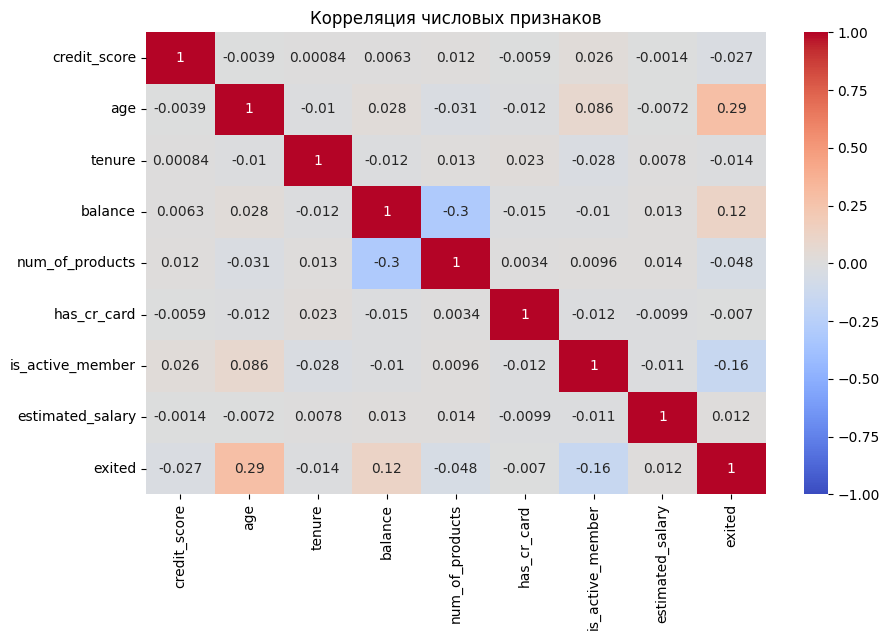

In [75]:
corr = dataset.corr(numeric_only=True)
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Корреляция числовых признаков")
plt.show()

Корреляционный анализ показал, что отток клиентов сильнее всего связан с возрастом (0.29) и активностью (–0.16), но не выявил других важных закономерностей, которые были обнаружены при исследовательском анализе. Это можно объяснить тем, что корреляция измеряет только линейные связи, когда в исследовательском анализе были найдены косвенные связи. Также стоит учесть, что в датасете присутствует мало данных (по сравнению со всей выборкой), которые подходят под закономерности из исследовательского анализа.  
> Также стоит учесть, что категориальные признаки в корреляцию не входят.

##### Анализ распределения числовых значений
Для столбцов с числовыми значениями составим гистограммы и выведем их

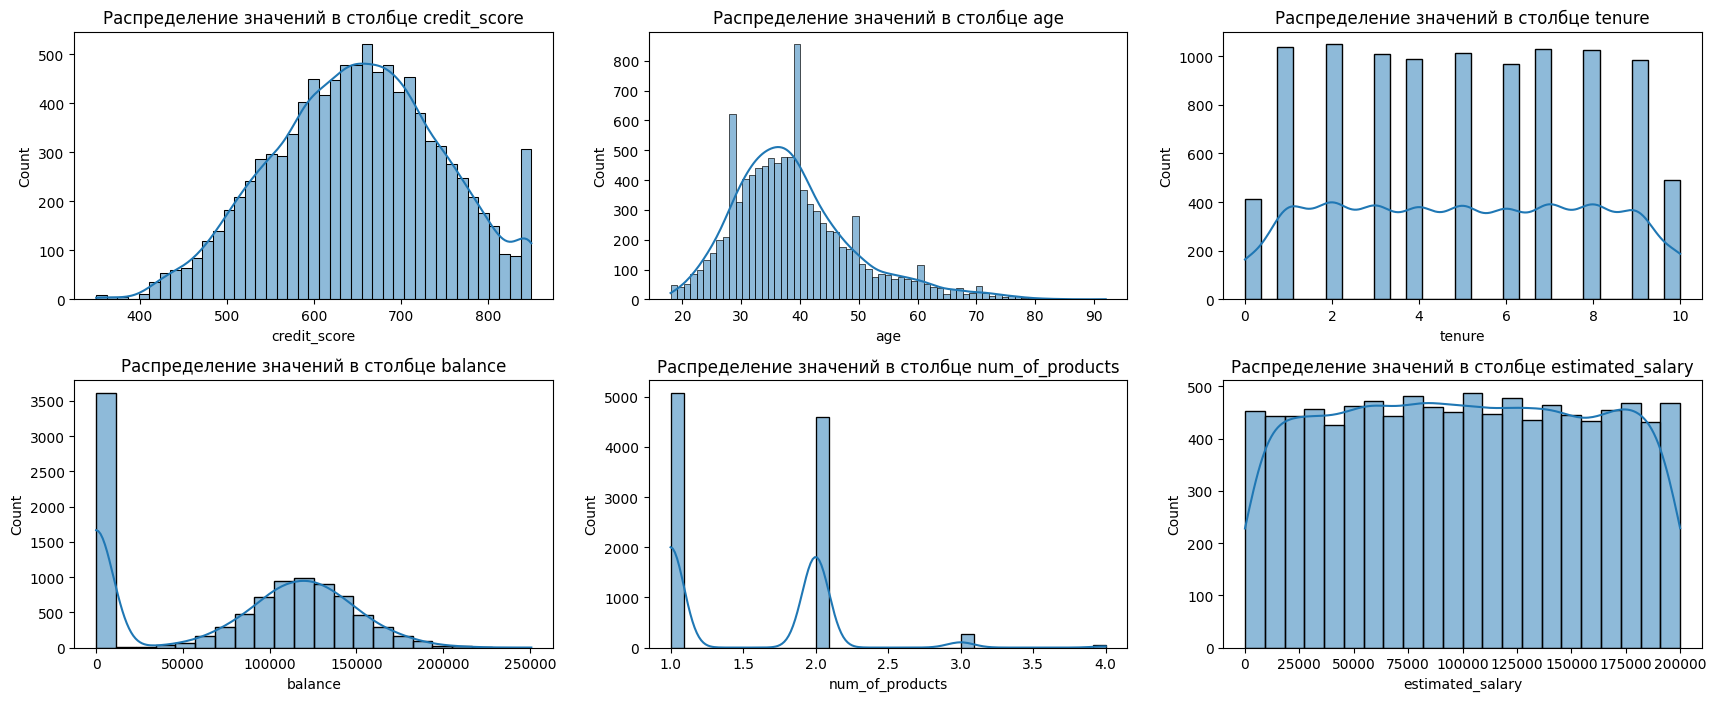

In [76]:
# гистограммы выведем с помощью subplots
# сначала для числовых значений
numeric_cols = dataset.select_dtypes(include="number").columns
n_plots = len(numeric_cols)
n_cols = 3
n_rows = math.ceil(n_plots / n_cols) 

fig, axes = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(7 * n_cols, 4 * n_rows),
    squeeze=False
)
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(dataset[col], kde=True, ax=axes[i])
    axes[i].set_title(f"Распределение значений в столбце {col}", fontsize=12)

plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.show()

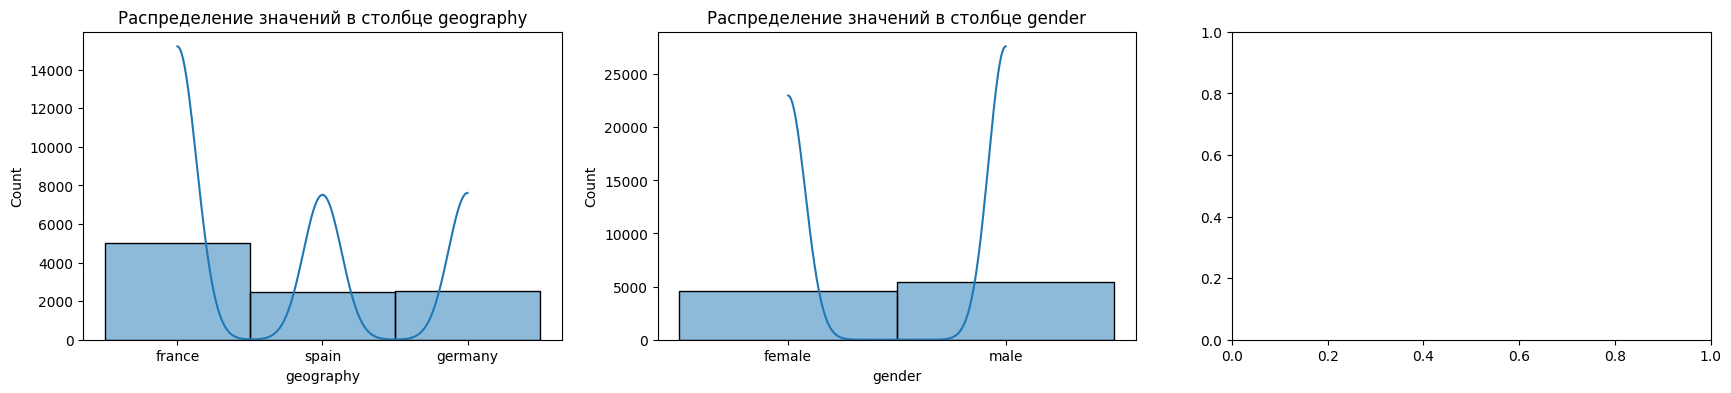

In [77]:
# для объектных значений
object_cols = dataset.select_dtypes(include="object").columns
n_plots = len(object_cols)
n_cols = 3
n_rows = math.ceil(n_plots / n_cols) 

fig, axes = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(7 * n_cols, 4 * n_rows),
    squeeze=False
)
axes = axes.flatten()

for i, col in enumerate(object_cols):
    sns.histplot(dataset[col], kde=True, ax=axes[i])
    axes[i].set_title(f"Распределение значений в столбце {col}", fontsize=12)

    


plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.show()

Кредитный рейтинг клиентов распределён близко к нормальному, большинство находятся в диапазоне от 600 до 700 баллов, что говорит о средней (т.к хороший рейтинг нами установлен от 750) надёжности клиентов.  Возрастная категория в основном представлена людьми от 30 до 45 лет, с пиком около 27 и 40 — это активная платежеспособная аудитория, при этом доля пожилых и очень молодых клиентов невелика.  
Срок обслуживания клиентов в банке распределён практически равномерно, но заметно, что клиентов с 10 годами обслуживания чуть меньше — это может свидетельствовать об оттоке клиентов.
При анализе баланса наблюдается резкое расхождение: большая часть клиентов вообще не держат деньги на счёте, в то время как у другой части баланс в районе 100–150 тысяч.  
Количество используемых продуктов в банке ограничивается в основном одним или двумя — очень мало тех, кто пользуется большим количеством услуг.  
Зарплаты распределены равномерно, что свидетельствует о синтетической генерации данных, но заголовок столбца "предполагаемая зарплата" уже указывает, что эти данные были сделаны с помощью машинного обучения.


##### Построение таблиц сопряженности
Составим следующие таблицы сопряженности:
1. Зависимость между гендером и оттоком
2. Зависимость между географией и оттоком
3. Зависимость между наличием кредитной карты и числом продуктов
4. Зависимость между возрастом и оттоком
5. Зависимость между сроком обслуживания в банке и оттоком
6. Зависимость между балансом и оттоком

In [78]:
# 1 зависимость гендера и оттока
gender_exit = pd.crosstab(
    index=dataset["gender"],
    columns=dataset["exited"],
    margins=True,
    margins_name="all",
    normalize="index"
).round(3) * 100

gender_exit

exited,False,True
gender,,
female,74.9,25.1
male,83.5,16.5
all,79.6,20.4


Здесь видно, что женщины уходят значительно чаще (25.1%), чем мужчины (16.5%). Это серьезный сигнал для маркетинга и продуктовой политики - возможно, сервисы банка недостаточно учитывают потребности женской аудитории.

In [79]:
# 2 зависимость географии и оттока
geo_exit = pd.crosstab(
    index=dataset["geography"],
    columns=dataset["exited"],
    margins=True,
    margins_name="all",
    normalize="index"
).round(3) * 100

geo_exit

exited,False,True
geography,,
france,83.8,16.2
germany,67.6,32.4
spain,83.3,16.7
all,79.6,20.4


По данной таблице Германия демонстрирует тревожный уровень оттока - 32.4%, что в 2 раза выше, чем во Франции (16.2%) и Испании (16.7%). Это может указывать на проблемы с локализацией сервиса или более жесткую конкуренцию на немецком рынке. Но это также может быть связано с большим средним балансом у Германии, как это было выявлено при исследовательском анализе

In [80]:
# 3 зависимость наличия кредитной карты и числом продуктов
card_products = pd.crosstab(
    index=dataset["has_cr_card"],
    columns=dataset["num_of_products"],
    margins=True,
    margins_name="all"
)

card_products

num_of_products,1,2,3,4,all
has_cr_card,,,,,
False,1507,1344,76,19,2946
True,3577,3246,190,41,7054
all,5084,4590,266,60,10000


Большинство клиентов (как с картой, так и без) используют 1-2 продукта. Интересно, что владельцы кредитных карт чаще используют 2 продукта, что подтверждает эффективность карты как инструмента кросс-продаж. Но это также может свидетельствовать об агрессивном маркетинге, когда кредитную карту навязывают клиенту в дополнение к интересующему продукту.

In [81]:
# 4 зависимость возраста и оттока. Для возраста определим возрастные категории
dataset_for_age = dataset.copy()

age_bins = [18, 30, 40, 50, 60, 95]
age_labels = ["18-30", "30-40", "40-50", "50-60", "60-95"]
dataset_for_age["age_group"] = pd.cut(dataset_for_age["age"], bins=age_bins, labels=age_labels)

age_exit = pd.crosstab(
    index=dataset_for_age["age_group"],
    columns=dataset_for_age["exited"],
    margins=True,
    margins_name="all",
    normalize="index"
).round(3) * 100

age_exit

exited,False,True
age_group,,
18-30,92.5,7.5
30-40,87.9,12.1
40-50,66.0,34.0
50-60,43.8,56.2
60-95,75.2,24.8
all,79.6,20.4


Явная возрастная зависимость: клиенты 50-60 лет уходят чаще всего (56.2%), тогда как молодежь 18-30 лет наиболее лояльна (7.5% оттока). Однако стоит учесть, что людей 50-60 в общей статистике мало и даже небольшой уход.  
Стоит обратить внимание на возрастную категорию 40-50, исходя из общей статистики видно, что таких людей много, но и отток составляет 34% - это крайне высокий показатель оттока.

In [82]:
# 5 зависимость срока обслуживания и оттока.
tenure_exit = pd.crosstab(
    index=dataset["tenure"],
    columns=dataset["exited"],
    margins=True,
    margins_name="all",
    normalize="index"
).round(3) * 100

tenure_exit

exited,False,True
tenure,,
0,77.0,23.0
1,77.6,22.4
2,80.8,19.2
3,78.9,21.1
4,79.5,20.5
5,79.3,20.7
6,79.7,20.3
7,82.8,17.2
8,80.8,19.2


По срокам обслуживания отток относительно равномерен, но есть интересные исключения: клиенты 7-го года обслуживания наиболее лояльны (17.2% оттока, что на 2% меньше с ближайшим показателем), а новички со сроком обслуживания до 1 года показывают самый высокий показатель оттока

In [83]:
# 6 зависимость баланса и оттока. Для баланса создадим категории
dataset_for_balance = dataset.copy()

balance_bins = [0, 30_000, 60_000, 90_000, 120_000, 150_000, 180_000, 210_000, 240_000]
balance_labels = ["0-30k", "30-60k", "60-90k", "90-120k", "120k-150k", "150k-180k", "180k-210k", "210k-240k"]

dataset_for_balance["balance_group"] = pd.cut(dataset_for_balance["balance"], bins=balance_bins, labels=balance_labels)

balance_exit = pd.crosstab(
    index=dataset_for_balance["balance_group"],
    columns=dataset_for_balance["exited"],
    margins=True,
    margins_name="all",
    normalize="index"
).round(4) * 100

balance_exit

exited,False,True
balance_group,,
0-30k,41.67,58.33
30-60k,74.13,25.87
60-90k,80.84,19.16
90-120k,74.33,25.67
120k-150k,75.54,24.46
150k-180k,78.62,21.38
180k-210k,70.07,29.93
210k-240k,50.00,50.00
all,75.93,24.07


Наблюдается странная ситуация: клиенты с низким (0-30k) и очень высоким (180k-240k) балансом уходят чаще всего (58.33% и 30% соответственно). Возможно, это связано с разными причинами: низкий баланс - с неудовлетворенностью сервисом, высокий - с привлекательными предложениями конкурентов для VIP-клиентов.

##### Проверка гипотез

Для проверки были выбраны следующие гипотезы:
1. География (geography) влияет на отток клиентов (exited). Данную гипотезу будем проверять с помощью x^2-теста (хи-квадрат)
2. Новые клиенты (tenure ≤ 1 год) с высоким кредитным рейтингом (credit_score >= 750) уходят чаще (exited=True), чем новые клиенты с низким рейтингом (credit_score < 750). Данную гмпотезу будем проверять с помощью t-теста, т.к проверяются 2 группы клиентов.

Проверять гипотезы будем с помощью библиотеки scipy - библиотеки для [научных вычислений](https://scipy.org/)

In [84]:
# воспользуемся таблицей сопряженности из статистического анализа
chi2, p_value, dof, expected = chi2_contingency(geo_exit)
print("Результат теста:")
print(f"x^2 = {chi2:.3f}, p-value = {p_value:.5f}")

Результат теста:
x^2 = 10.165, p-value = 0.01721


Результат χ^2-теста (p-value = 0.017 < 0.05) показывает, что отток клиентов статистически значимо зависит от географии. Это означает, что в некоторых странах клиенты уходят чаще, чем в других.

In [85]:
# проверка 2 гипотезы
new_customers = dataset[dataset["tenure"] <= 1]
high_score_new_customers = new_customers[new_customers["credit_score"] >= 750]["exited"]
low_score_new_customers = new_customers[new_customers["credit_score"] < 750]["exited"]

t_stat, p_value = ttest_ind(high_score_new_customers, low_score_new_customers, equal_var=False)

print(f"t-статистика = {t_stat:.3f}")
print(f"p-value = {p_value:.5f}")

t-статистика = -1.003
p-value = 0.31658


Из данной проверки результат следующий - нет статистически значимых доказательств (p-value = 0.31658), что новые клиенты с высоким кредитным рейтингом (credit_score >= 750) уходят чаще, чем новые клиенты с низким рейтингом (credit_score > 750)  
Отрицательное значение t-статистики говорит о том, что в среднем отток в группе с высоким кредитным рейтингом ниже, чем в группе с низким, но разница незначима.
Это значит, что гипотеза не подтверждена, но при исследовательском анализе было выявлено, что клиенты со сроком обслуживания в банке до года и с высоким кредитным рейтингом показывают высокий отток. Возможно, необходима другая статистическая проверка из-за небольшого количества клиентов в данной группе по сравнению со всем датасетом.

##### Вывод по статистическому анализу

В ходе статистического анализа с использованием методов визуализации распределений, группировки по целевому признаку `exited`, а также анализа средних и долей, были выявлены важные зависимости, влияющие на уход клиентов.  
Анализ показал, что чаще всего уходят клиенты предпенсионного возраста (50-60 лет) и те, кто пользуется только одним продуктом банка (но это можно объяснить тем, что их половина от всей выборки). Это говорит о важности работы с вовлечённостью и необходимости предложений по расширению продуктовой линейки в банке.  
Также выявлено, что часть клиентов с высоким балансом и хорошим кредитным рейтингом всё равно покидают банк — вероятно, не чувствуя ценности от текущих услуг. Это ключевая группа для удержания и персонализированных предложений.
Также благодаря проверки гипотез была установлена взаимосвязь между оттоком и географией и благодаря статистическому анализу установлено, что самый большой отток показывают клиенты из Германии. Эти данные дают банку четкое понимание, что необходимо более детально разобраться в причинах такого оттока именно в Германии.
